# Sliding Window Attention (滑动窗口注意力)

## 1. Introduction (简介)

Used in models like **Mistral 7B**, Sliding Window Attention (SWA) limits each token to attend only to a fixed number of previous tokens ($W$).
以 **Mistral 7B** 为代表的模型使用了滑动窗口注意力 (SWA)，它限制每个 token 只能关注过去固定数量的 tokens ($W$)。

### Why? (为什么？)
1. **Efficiency (效率)**: Complexity reduces from $O(L^2)$ to $O(L \times W)$. 注意力计算复杂度降低。
2. **KV Cache**: You only need to store the last $W$ tokens in the cache (Fixed size Ring Buffer). 只需要固定大小的缓存。

### The Trick: Receptive Field (感受野)
Even with a window $W$, efficient information propagation happens across layers.
- Layer 1: Token $t$ sees $[t-W, t]$.
- Layer 2: Token $t$ attends to tokens in Layer 1, which effectively saw $[t-2W, t]$.
- ...
Thus, deeper layers have a theoretical receptive field much larger than $W$.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import math
def plot_attention_mask(mask, title="Attention Mask"):
    plt.figure(figsize=(6, 6))
    sns.heatmap(mask.cpu().numpy(), square=True, cbar=False, cmap="Blues")
    plt.title(title)
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")
    plt.show()

## 2. Creating the Mask (创建掩码)

Standard Causal Mask allows seeing everything before $t$ (lower triangular).
Sliding Window Mask creates a "band" (对角带状) matrix.

Let's implement a function to generate this mask.

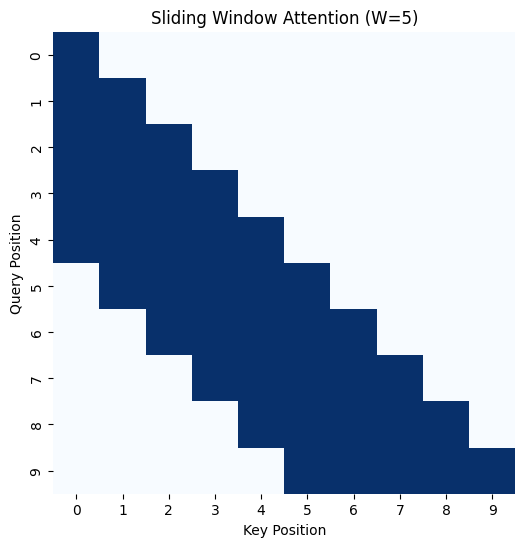

In [2]:
def create_sliding_window_mask(seq_len, window_size):
    """
    Creates a mask where matrix[i, j] = 1 if j <= i and i - j < window_size
    Otherwise 0 (or -inf in practice).
    """
    # 1. Create indices
    indices = torch.arange(seq_len)
    # shape: (seq_len, 1) and (1, seq_len)
    rows = indices.view(-1, 1)
    cols = indices.view(1, -1)
    
    # 2. Causal constraint: query (row) must be >= key (col) -> rows >= cols
    causal_mask = rows >= cols   #下三角

    # 3. Window constraint: distance (rows - cols) must be < window_size
    window_mask = (rows - cols) < window_size  #在windows_size之上的上三角
    # Combine
    final_mask = causal_mask & window_mask
    
    # Convert to float mask for attention (0 for keep, -inf for mask)
    # Usually we add this to attention scores.
    # Here we just return 1s and 0s for visualization.
    return final_mask.float()

# Visualize
L = 10
W = 5
mask = create_sliding_window_mask(L, W)
plot_attention_mask(mask, title=f"Sliding Window Attention (W={W})")

## 3. Applying it (应用)

In a real implementation, you would add this mask to the attention scores before Softmax.

```python
scores = Q @ K.T / sqrt(d)
scores = scores.masked_fill(mask == 0, float('-inf'))
probs = softmax(scores)
```

### Note on "Rolling Buffer" Cache
Mistral implementation is clever. Instead of shifting tensors (slow), they use a **Rolling Buffer** (rotating index) for the KV cache.

Example for Cache Size 4:
- Step 1: `[t1, 0, 0, 0]`
- Step 4: `[t1, t2, t3, t4]`
- Step 5: `[t5, t2, t3, t4]` (Overwrite index 0)
- Step 6: `[t5, t6, t3, t4]` (Overwrite index 1)

This avoids memory allocation overhead.

## 4.实现Sliding Window Attention

In [3]:
class SlidingWindowAttention(nn.Module):
    def __init__(self, d_model, n_heads, window_size):
        """
        滑动窗口注意力机制
        Args:
            d_model: 词嵌入维度 d
            n_heads: 注意力头的数量 h
            window_size: 滑动窗口大小 w
        """
        super(SlidingWindowAttention, self).__init__()
        assert d_model % n_heads == 0 ,"d_model must be divisible by n_heads"
        assert window_size % 2   == 1  ,"window_size must be odd"
        self.d_model = d_model
        self.n_heads = n_heads
        self.window_size = window_size
        self.head_dim = d_model // n_heads  # 每个头的维度
        
        # 线性投影层
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)
        self.o_proj = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        """
        前向传播
        Args:
            x: 输入张量 [batch, seq_len, d_model]
        
        Returns:
            输出张量 [batch, seq_len, d_model]
        """
        batch_size, seq_len, _ = x.shape

        # 计算 Q, K, V
        Q = self.q_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)  # [b, h, seq, d]
        K = self.k_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)

        # 初始化注意力矩阵
        attn_scores = torch.full((batch_size, self.n_heads, seq_len, seq_len), float("-inf"), device=x.device)

        # 计算滑动窗口注意力
        for i in range(seq_len):
            # Symmetric Window: [i - window_size, i + window_size]
            start = max(0, i - self.window_size)
            end = min(seq_len, i + self.window_size + 1)
            """
            这里的start和end是非因果的，会整合Qi前后的信息
            如果是casual(因果)的:
            start = max(0, i - self.window_size)
            end = min(seq_len, i + 1) 
            即Qi只能看到Qi当前即之前的K
            """
            # Slice Q to keep dimensions [b, h, 1, d] instead of [b, h, d]
            # This fixes the broadcasting error
            Q_i = Q[:, :, i:i+1, :] 
            
            # Matmul: [b, h, 1, d] @ [b, h, d, window_len] -> [b, h, 1, window_len]
            # Squeeze(2) 为了和左边的维度匹配 [b, h, window_len]
            attn_scores[:, :, i, start:end] = torch.matmul(Q_i, K[:, :, start:end, :].transpose(-2, -1)).squeeze(2) 

        print(attn_scores.shape,attn_scores[0][0][9], attn_scores[0][0][64])
        # 归一化
        attn_scores /= math.sqrt(self.head_dim)
        attn_weights = F.softmax(attn_scores, dim=-1)

        # 计算注意力加权的 Value
        output = torch.matmul(attn_weights, V)

        # 重新排列形状
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.o_proj(output)  # 线性变换回原始维度

        return output


d_model = 512
n_heads = 8
window_size = 9

swa = SlidingWindowAttention(d_model=d_model, n_heads=n_heads, window_size=window_size)
x = torch.randn(1, 128, d_model)
y = swa(x)

torch.Size([1, 8, 128, 128]) tensor([ 2.0678, -3.6940, -0.6472, -7.1638, -1.2749, -3.4011, -2.5821, -0.3916,
         2.4040, -0.3029,  1.6366, -0.0361, -2.5846, -7.1261, -0.3947, -0.5864,
        -4.5202, -1.0975, -3.2847,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           

In [4]:
#  b的shape会变成[10, 5] 而不是[10, 1, 5]
a =  torch.randn(10, 3, 5)
b = a[:, 1, :]
print(b.shape)

torch.Size([10, 5])


### SWA的优缺点

#### 优点
1.  计算复杂度降低：从 $O(N^2)$ 降到 $O(N*W)$
2.  可以拓展到长序列
3.  使用于文档级任务
#### 缺点
1.  不能远距离捕捉依赖
2.  需要全局注意力补充

### 增强远程依赖能力方法
### 1. 结合全局注意力（Gobal Attention）
  全局注意力指的是我们将某些位置的Token设置为全局Token，即它会与其它所有Token进行注意力计算。而其它Token则会和窗内Token以及全局Token进行交互。
e.g. 假如总共有10个Token，Token 0是全局Token，Token 1-9是窗内Token。 那么Token 0 会和Token 1-9进行注意力计算，Token 1-9会和Token 0 以及窗内Token进行注意力计算。
### 2. 结合扩张窗口注意力(Dilated Window Attention)

In [ ]:
class SWA_With_Global(nn.Module):
    def __init__(self, d_model, n_heads, window_size, num_global_tokens=1):
        """
        Sliding Window Attention with Global Tokens
        Args:
            d_model: embedding dimension d
            n_heads: number of attention heads h
            window_size: sliding window size w
            num_global_tokens: number of global tokens (g) at the start of the sequence.
        """
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.window_size = window_size
        self.num_global_tokens = num_global_tokens
        self.head_dim = d_model // n_heads
        
        assert self.head_dim * self.n_heads == self.d_model, "d_model must be divisible by n_heads"

        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)
        self.o_proj = nn.Linear(d_model, d_model, bias=False)
    
    def forward(self, x):
        """
        Args:
            x: input sequence of shape (batch_size, seq_len, d_model)
        Returns:
            output: attention output of shape (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, _ = x.shape
        Q = self.q_proj(x).contiguous().view(batch_size, seq_len, self.n_heads, -1).permute(0, 2, 1, 3)
        K = self.k_proj(x).contiguous().view(batch_size, seq_len, self.n_heads, -1).permute(0, 2, 1, 3)
        V = self.v_proj(x).contiguous().view(batch_size, seq_len, self.n_heads, -1).permute(0, 2, 1, 3)

        attn_scores = torch.full((batch_size, self.n_heads, seq_len, seq_len), float('-inf'), device=x.device)
        
        for i in range(seq_len):
            if i < self.num_global_tokens:
                # 全局Attention
                Qi = Q[:, :, i:i+1, :]
                attn_scores[:, :, i, :] = torch.matmul(Qi, K.transpose(-2, -1)).squeeze(2)
            else:
                # 局部Attention： 窗口＋全局Token
                global_end = min(seq_len, self.num_global_tokens)

                #窗口indices:
                win_start = max(0, i - self.window_size)
                win_end = min(seq_len, i + self.window_size + 1)
                
                #全局Keys:
                K_Global = K[:, :, :global_end, :]

                #处理窗口和全局Tokens关系
                #实际窗口起点：
                eff_win_start = max(win_start, global_end)
                if eff_win_start < win_end:
                    K_window = K[:, :, eff_win_start:win_end, :]
                    K_select = torch.cat([K_Global, K_window], dim=2)
                    cols = list(range(global_end)) + list(range(eff_win_start, win_end)) #选取做注意力Tokens的位置
                else:
                    K_select = K_Global
                    cols = list(range(global_end))

                Qi = Q[:, :, i:i+1, :]
                attn_scores[:, :, i, cols] = torch.matmul(Qi, K_select.transpose(-2, -1)).squeeze(2)
        
        attn_scores /= math.sqrt(self.head_dim)
        attn_weights = F.softmax(attn_scores, dim=-1)

        output = torch.matmul(attn_scores, V)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.o_proj(output)

        return output

In [8]:
d_model = 64
n_heads = 4
window_size = 2
num_global = 2
seq_len = 10

model = SWA_With_Global(d_model, n_heads, window_size, num_global_tokens=num_global)
x = torch.randn(1, seq_len, d_model, requires_grad=True)
    
    
output = model(x)
print("Forward pass successful! Output shape:", output.shape)

Forward pass successful! Output shape: torch.Size([1, 10, 64])
